# Welcome

This notebook explores the K-Nearest Neighbors (KNN) algorithm through two experiments:

1.  **Visualizing KNN Decision Boundaries:** This experiment demonstrates how the `k` parameter affects the decision boundary of a KNN classifier using the Iris dataset and visualizes the results.
2.  **KNN Sensitivity Tests:** This experiment investigates the impact of feature scaling and the presence of noise features on KNN performance using the Wine dataset and analyzes the results across different scenarios.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
RANDOM_STATE = 42

# Experiment 1: Visualizing KNN

In this experiment, we will visualize the decision boundaries of a K-Nearest Neighbors (KNN) classifier on the Iris dataset using the first two features (sepal length and sepal width). We will train two KNN models, one with `k=1` and another with `k=11`.


## Loading and spitting data

This code loads the Iris dataset and splits it into training and testing sets. It specifically selects the first two features for visualization purposes.

In [ ]:
iris = load_iris()
X_2d = iris.data[:, :2]  # use first two features for clean 2D plotting
y = iris.target
feature_names_2d = [iris.feature_names[0], iris.feature_names[1]]

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

## Visualization function

This code defines a function plot_decision_boundary that takes a trained pipeline, data for plotting, and a title as input. It creates a mesh grid to plot the decision boundary of the classifier and overlays the data points.

In [ ]:
def plot_decision_boundary_subplot(pipeline, X_plot, y_plot, title, ax, feature_names):
    # create mesh
    h = 0.02
    x_min, x_max = X_plot[:, 0].min() - 1.0, X_plot[:, 0].max() + 1.0
    y_min, y_max = X_plot[:, 1].min() - 1.0, X_plot[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = pipeline.predict(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)  # default colormap
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, s=30)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)

## Fitting and visualizing

Experiment 1: Decision boundary visualization (Iris, features: sepal length (cm) and sepal width (cm))


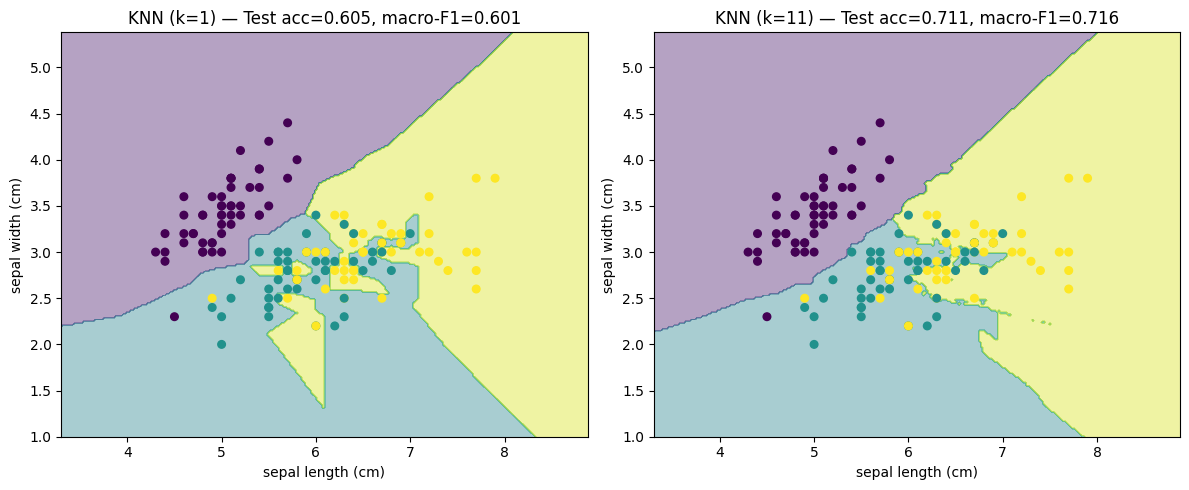

In [ ]:
print("Experiment 1: Decision boundary visualization (Iris, features: {} and {})".format(*feature_names_2d))
ks = [1, 11]
fig, axes = plt.subplots(1, len(ks), figsize=(12, 5)) # Create a figure and a set of subplots
for i, k in enumerate(ks):
    pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))])
    pipe.fit(X_train_2d, y_train_2d)
    y_pred = pipe.predict(X_test_2d)
    acc = accuracy_score(y_test_2d, y_pred)
    f1 = f1_score(y_test_2d, y_pred, average="macro")
    title = f"KNN (k={k}) — Test acc={acc:.3f}, macro-F1={f1:.3f}"
    # plot using both training and test points so the reader sees full distribution
    X_for_plot = np.vstack([X_train_2d, X_test_2d])
    y_for_plot = np.hstack([y_train_2d, y_test_2d])
    # Modify the plot_decision_boundary function call to use the axes object
    plot_decision_boundary_subplot(pipe, X_for_plot, y_for_plot, title, ax=axes[i], feature_names=feature_names_2d)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the figure

## Summary of Experiment 1

**Observations:**

- **`k=1`:** The decision boundary for `k=1` is very complex and follows the individual data points closely. This indicates that the model is overfitting to the training data, resulting in a lower test accuracy (0.605) and macro-F1 score (0.601).
- **`k=11`:** The decision boundary for `k=11` is much smoother and generalizes better to the test data. This is reflected in the higher test accuracy (0.711) and macro-F1 score (0.716) compared to `k=1`.

This experiment demonstrates the impact of the `k` parameter on the KNN classifier's decision boundary and its ability to generalize to unseen data. A smaller `k` can lead to overfitting, while a larger `k` can result in a smoother decision boundary and better generalization.

# Experiment 2: KNN sensitivity tests (Wine dataset)

In this experiment, we will investigate the sensitivity of the K-Nearest Neighbors (KNN) classifier to feature scaling and the presence of irrelevant noise features using the Wine dataset. We evaluated the model's performance across three scenarios over 10 random train-test splits:

- **`baseline_scaled`**: Features are scaled using `StandardScaler`.
- **`no_scaling`**: Raw, unscaled features are used.
- **`with_noise_20`**: Features are scaled, and 20 irrelevant Gaussian noise features are added.

## Load data

In [ ]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

In [ ]:
# Count the occurrences of each unique value in the NumPy array
unique_classes, counts = np.unique(y_wine, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count}")

Class 0: 59
Class 1: 71
Class 2: 48


## Evaluation function

In [ ]:
def evaluate_knn_runs(X, y, scale=True, noise_features=0, n_runs=10, n_neighbors=5):
    rng = np.random.RandomState(RANDOM_STATE)
    results = []
    for i in range(n_runs):
        # create noise if requested (same number of rows, noise_features cols)
        X_aug = X.copy()
        if noise_features > 0:
            noise = rng.normal(loc=0.0, scale=1.0, size=(X.shape[0], noise_features))
            X_aug = np.hstack([X_aug, noise])
        # split with a changing random_state for variation
        rs = RANDOM_STATE + i
        X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.2, stratify=y, random_state=rs)
        if scale:
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        results.append({"run": i, "accuracy": acc, "macro_f1": f1})
    df = pd.DataFrame(results)
    summary = {
        "mean_accuracy": df["accuracy"].mean(),
        "std_accuracy": df["accuracy"].std(),
        "mean_macro_f1": df["macro_f1"].mean(),
        "std_macro_f1": df["macro_f1"].std(),
    }
    return summary, df

## Fitting and result generation

In [ ]:
scenarios = {
    "baseline_scaled": {"scale": True, "noise": 0},
    "no_scaling": {"scale": False, "noise": 0},
    "with_noise_20": {"scale": True, "noise": 20},
}

summary_rows = []
detail_dfs = {}

for name, conf in scenarios.items():
    print(f"Running scenario: {name} (scale={conf['scale']}, noise={conf['noise']})")
    summary, df_runs = evaluate_knn_runs(X_wine, y_wine, scale=conf['scale'], noise_features=conf['noise'], n_runs=10, n_neighbors=5)
    row = {
        "scenario": name,
        "scale": conf["scale"],
        "noise_features": conf["noise"],
        "mean_accuracy": summary["mean_accuracy"],
        "std_accuracy": summary["std_accuracy"],
        "mean_macro_f1": summary["mean_macro_f1"],
        "std_macro_f1": summary["std_macro_f1"],
    }
    summary_rows.append(row)
    detail_dfs[name] = df_runs

df_summary = pd.DataFrame(summary_rows).sort_values("scenario").reset_index(drop=True)

Running scenario: baseline_scaled (scale=True, noise=0)
Running scenario: no_scaling (scale=False, noise=0)
Running scenario: with_noise_20 (scale=True, noise=20)


In [ ]:
df_summary

,scenario,scale,noise_features,mean_accuracy,std_accuracy,mean_macro_f1,std_macro_f1
0,baseline_scaled,True,0,0.963889,0.026352,0.964505,0.026041
1,no_scaling,False,0,0.708333,0.070820,0.681155,0.083720
2,with_noise_20,True,20,0.925000,0.055633,0.926281,0.056859


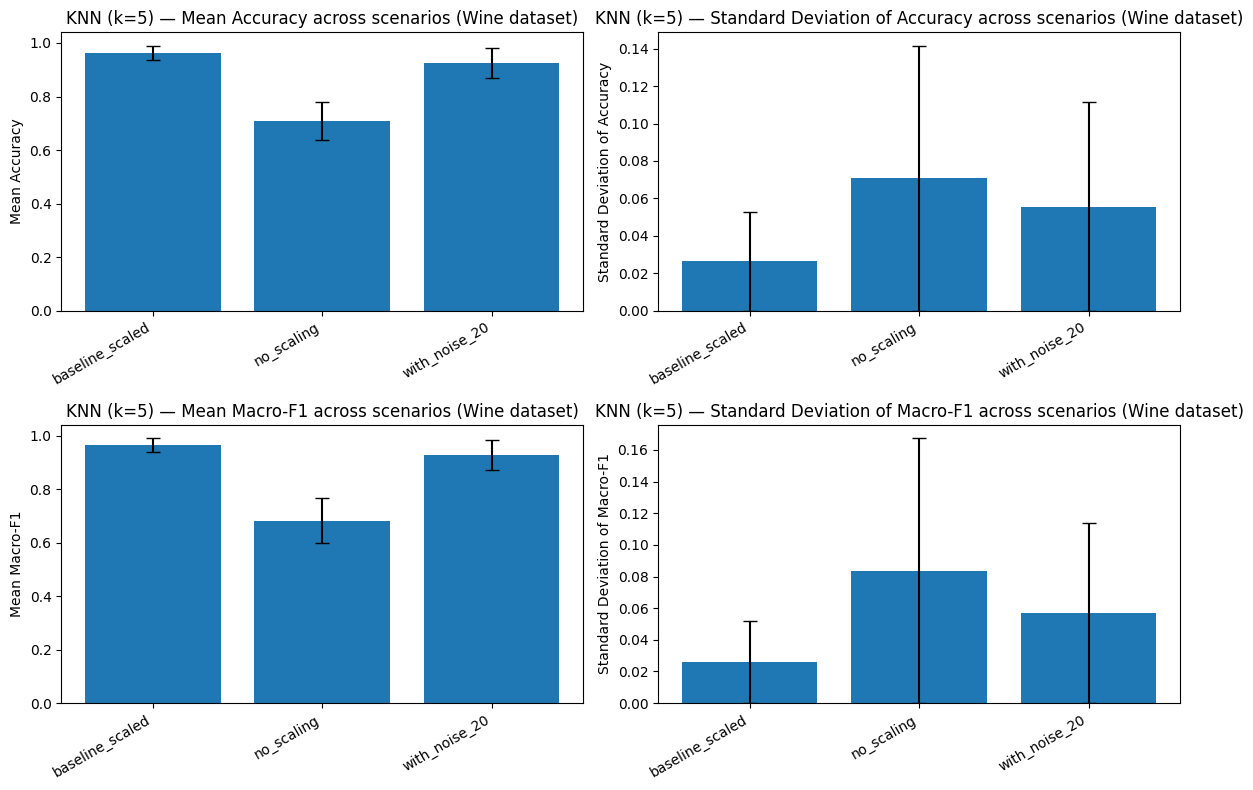

In [ ]:
metrics = {
    "mean_accuracy": "Mean Accuracy",
    "std_accuracy": "Standard Deviation of Accuracy",
    "mean_macro_f1": "Mean Macro-F1",
    "std_macro_f1": "Standard Deviation of Macro-F1",
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten() # Flatten the 2x2 array of axes to easily iterate

x = np.arange(len(df_summary))

for i, (metric_col, metric_title) in enumerate(metrics.items()):
    axes[i].bar(x, df_summary[metric_col], yerr=df_summary[metric_col.replace("mean", "std") if "mean" in metric_col else metric_col], capsize=5)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(df_summary["scenario"], rotation=30, ha="right")
    axes[i].set_ylabel(metric_title)
    axes[i].set_title(f"KNN (k=5) — {metric_title} across scenarios (Wine dataset)")

plt.tight_layout()
plt.show()

## Summary of Results — Experiment 2

The results are summarized in the table and visualized in the bar plots above:

**Observations:**

- **Effect of Scaling (`baseline_scaled` vs. `no_scaling`):**
    - The `baseline_scaled` scenario (mean accuracy: 0.964, mean macro-F1: 0.965) significantly outperformed the `no_scaling` scenario (mean accuracy: 0.708, mean macro-F1: 0.681).
    - This highlights the critical importance of feature scaling for KNN. KNN relies on distance calculations, and features with larger scales can disproportionately influence the distance metric, leading to poor performance. Scaling ensures all features contribute relatively equally to the distance.
    - The standard deviation of performance metrics was also lower for the scaled scenario, indicating more consistent results across different train-test splits.

- **Effect of Noise Features (`baseline_scaled` vs. `with_noise_20`):**
    - Adding 20 irrelevant noise features in the `with_noise_20` scenario (mean accuracy: 0.925, mean macro-F1: 0.926) resulted in a slight decrease in performance compared to the `baseline_scaled` scenario (mean accuracy: 0.964, mean macro-F1: 0.965).
    - While scaling helps mitigate the impact of noise, the presence of completely irrelevant features still introduces some noise into the distance calculations, leading to a modest drop in accuracy and F1-score.
    - The standard deviation of performance metrics was higher in the `with_noise_20` scenario compared to `baseline_scaled`, suggesting that the impact of noise can vary depending on the specific random split of the data.

**Conclusion:**

Experiment 2 demonstrates that feature scaling is crucial for achieving good performance with KNN. While scaling helps make the model more robust to irrelevant features, their presence can still negatively impact performance. Feature selection or dimensionality reduction techniques could potentially be used to further improve performance in the presence of many irrelevant features.